              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   a

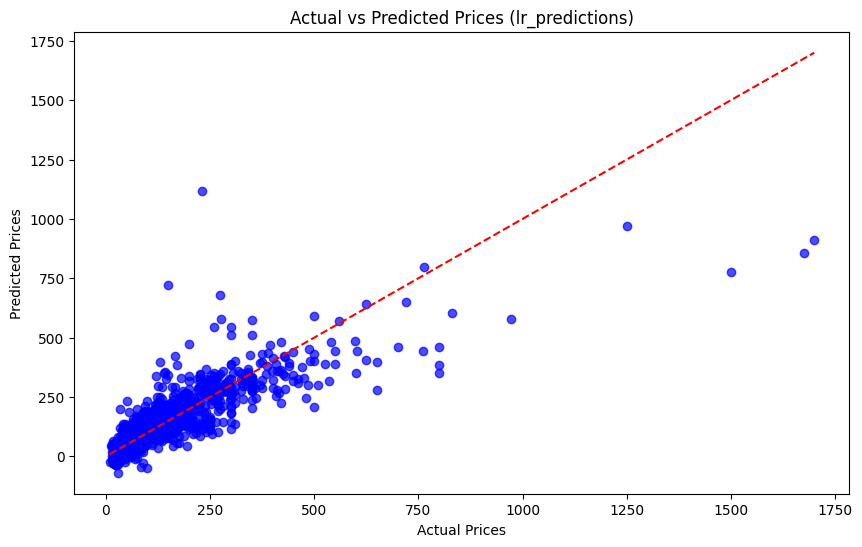

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# import xgboost as xgb

# Load the dataset (replace 'bangalore_house_data.csv' with your actual file path)
data = pd.read_csv('Bengaluru_House_Data.csv')

# Explore the data
print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Drop unnecessary columns (adjust based on your dataset)
data = data.drop(['area_type', 'society', 'balcony', 'availability'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Feature Engineering: Handle 'size' column
# Extract numeric values (e.g., '2 BHK' -> 2)
data['BHK'] = data['size'].apply(lambda x: int(x.split(' ')[0]))
data = data.drop(['size'], axis=1)

# Feature Engineering: Handle 'total_sqft'
def convert_sqft_to_num(x):
    try:
        return float(x)
    except:
        # Handle ranges (e.g., '1200-1500') by taking the average
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        # Return NaN for non-convertible values
        return None

# Apply the conversion
data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data = data.dropna(subset=['total_sqft'])

# Create a new feature 'price_per_sqft'
data['price_per_sqft'] = data['price'] * 100000 / data['total_sqft']

# Handle 'location' column (high cardinality)
data['location'] = data['location'].apply(lambda x: x.strip())
location_stats = data['location'].value_counts()

# Group less frequent locations into 'other'
location_stats_less_than_10 = location_stats[location_stats <= 10]
data['location'] = data['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# Remove outliers: Price per sqft threshold
data = data[(data['price_per_sqft'] > 300) & (data['price_per_sqft'] < 25000)]

# Remove BHK outliers (e.g., very small apartments with unrealistic prices)
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqft']),
                'std': np.std(bhk_df['price_per_sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft'] < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

data = remove_bhk_outliers(data)

# Drop the 'price_per_sqft' column as it's no longer needed
data = data.drop(['price_per_sqft'], axis=1)

# One-hot encode the 'location' column
data = pd.get_dummies(data, columns=['location'], drop_first=True)

# Split the dataset into features and target
X = data.drop(['price'], axis=1)
y = data['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a model: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_predictions)))
print("Linear Regression R^2:", r2_score(y_test, lr_predictions))

# Train a model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_predictions)))
print("Random Forest R^2:", r2_score(y_test, rf_predictions))

# # Train a model: XGBoost
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
# xgb_model.fit(X_train, y_train)
# xgb_predictions = xgb_model.predict(X_test)
# print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_predictions)))
# print("XGBoost R^2:", r2_score(y_test, xgb_predictions))

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, alpha=0.7, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (lr_predictions)')
plt.show()
